In [1]:
import time

import numpy as np
import matplotlib.pyplot as plt
from typing import List
import pysr

import sympy
import numpy as np
from matplotlib import pyplot as plt
from pysr import PySRRegressor
from sklearn.model_selection import train_test_split

# Configure plot defaults
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["grid.color"] = "#666666"

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


## MF-SRegressor for the classical MF problem: Forrester function

In [2]:
# original code
#  https://github.com/EmuKit/emukit/blob/main/emukit/test_functions/forrester.py


def forrester(x, sd=0):
    """
    Forrester function
    :param x: input vector to be evaluated
    :param sd: standard deviation of noise parameter
    :return: outputs of the function
    """
    x = x.reshape((len(x), 1))
    n = x.shape[0]
    fval = ((6 * x - 2) ** 2) * np.sin(12 * x - 4)
    if sd == 0:
        noise = np.zeros(n).reshape(n, 1)
    else:
        noise = np.random.normal(0, sd, n).reshape(n, 1)
    return fval.reshape(n, 1) + noise


def forrester_low(x, sd=0):
    """
    Low fidelity forrester function approximation:
    :param x: input vector to be evaluated
    :param sd: standard deviation of observation noise at low fidelity
    :return: outputs of the function
    """
    high_fidelity = forrester(x, 0)
    return (
        0.5 * high_fidelity
        + 10 * (x[:, [0]] - 0.5)
        + 5
        + np.random.randn(x.shape[0], 1) * sd
    )

In [3]:
high_fidelity = forrester
low_fidelity = forrester_low

x_plot = np.linspace(0, 1, 200)[:, None]
y_plot_l = low_fidelity(x_plot)
y_plot_h = high_fidelity(x_plot)

x_train_l = np.atleast_2d(np.random.rand(60)).T
x_train_h = np.atleast_2d(np.random.permutation(x_train_l)[:20])
y_train_l = low_fidelity(x_train_l)
y_train_h = high_fidelity(x_train_h)

In [4]:
y_train_h.shape, y_train_l.shape, x_train_h.shape, x_train_l.shape, x_plot.shape, y_plot_h.shape, y_plot_l.shape

((20, 1), (60, 1), (20, 1), (60, 1), (200, 1), (200, 1), (200, 1))

In [5]:
# Remove the first dimension
x_train_l = x_train_l
x_train_h = x_train_h
y_train_l = y_train_l[:, 0]
y_train_h = y_train_h[:, 0]
x_plot = x_plot
y_plot_h = y_plot_h[:, 0]
y_plot_l = y_plot_l[:, 0]

Text(0.5, 1.0, 'High and low fidelity functions')

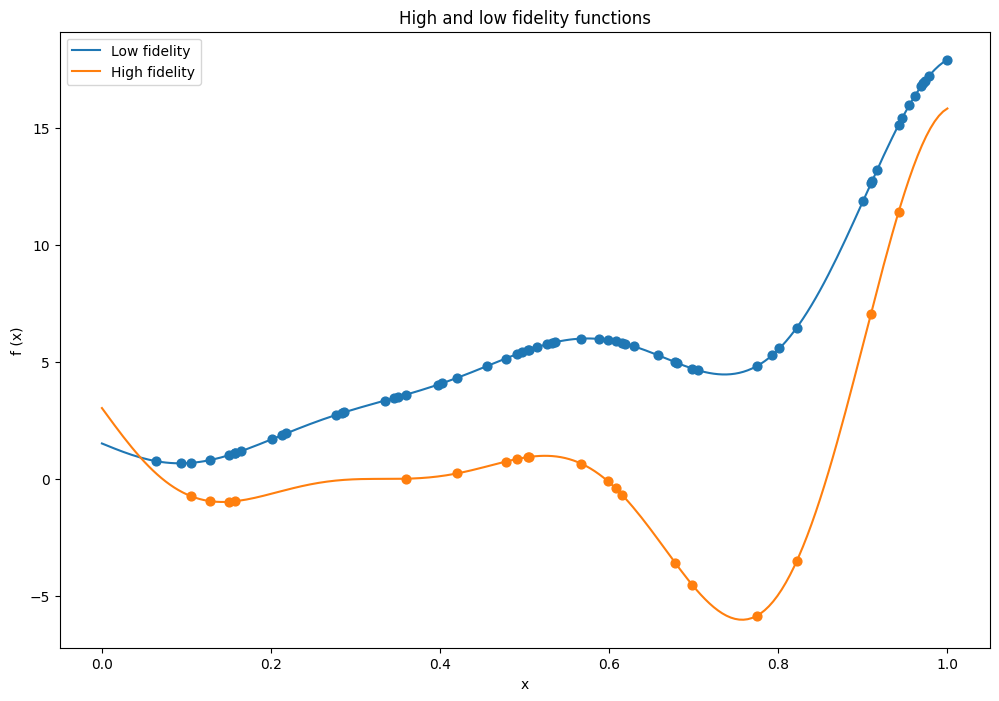

In [6]:
## Plot the original functions

plt.figure(figsize=(12, 8))
plt.plot(x_plot, y_plot_l, "C0")
plt.plot(x_plot, y_plot_h, "C1")
plt.scatter(x_train_l, y_train_l, color="C0", s=40)
plt.scatter(x_train_h, y_train_h, color="C1", s=40)
plt.ylabel("f (x)")
plt.xlabel("x")
plt.legend(["Low fidelity", "High fidelity"])
plt.title("High and low fidelity functions")

## MF-SR

In [7]:
class MultiFidelitySRegressor:
    """
    Multi-fidelity surrogate model that predicts the high-fidelity function.

    Parameters
    ----------
    model : PySRRegressor
        Low-fidelity model.
    model_mf : PySRRegressor
        Multi-fidelity model.
    complexity : int
        Complexity of the multi-fidelity model.
    """
    def __init__(self, model, model_mf, complexity=1):
        self.model = model
        self.model_mf = model_mf
        self.complexity = complexity

    def fit(self, x_l, y_l, x_h, y_h):
        """
        Fit the multi-fidelity model.

        Parameters
        ----------
        x_l : array-like
            Low-fidelity input data.
        y_l : array-like
            Low-fidelity target data.
        x_h : array-like
            High-fidelity input data.
        y_h : array-like
            High-fidelity target data.
        """
        # train LF model
        self.model.fit(x_l, y_l)
        # Predict LF model on HF input data
        f_l = self.model.predict(x_h)

        # Stack the LF model predictions with the HF input data
        _x_h = np.hstack([x_h, f_l[:, None]])

        self.model_mf.fit(_x_h, y_h)

    def predict(self, x):
        """
        Predict the high-fidelity function.
        """
        f_l = self.model.predict(x)
        _x = np.hstack([x, f_l[:, None]])
        return self.model_mf.predict(_x, self.complexity)

    def sympy(self):
        return self.model.sympy(), self.model_mf.sympy(self.complexity)

    def __call__(self, x):
        return self.predict(x)

    def __repr__(self):
        return f"MultiFidelitySRegressor(model={self.model}, model_mf={self.model_mf}, complexity={self.complexity})"

/Users/jibanmac/Documents/conda/emu-3.9/lib/python3.9/site-packages/pysr/sr.py:2582: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/Users/jibanmac/Documents/conda/emu-3.9/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/jibanmac/Documents/conda/emu-3.9/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Compiling Julia backend...


[ Info: Started!
/Users/jibanmac/Documents/conda/emu-3.9/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/jibanmac/Documents/conda/emu-3.9/lib/python3.9/site-packages/pysr/sr.py:2582: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/Users/jibanmac/Documents/conda/emu-3.9/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/jibanmac/Documents/conda/emu-3.9/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceW

Text(0.5, 1.0, 'High fidelity function')

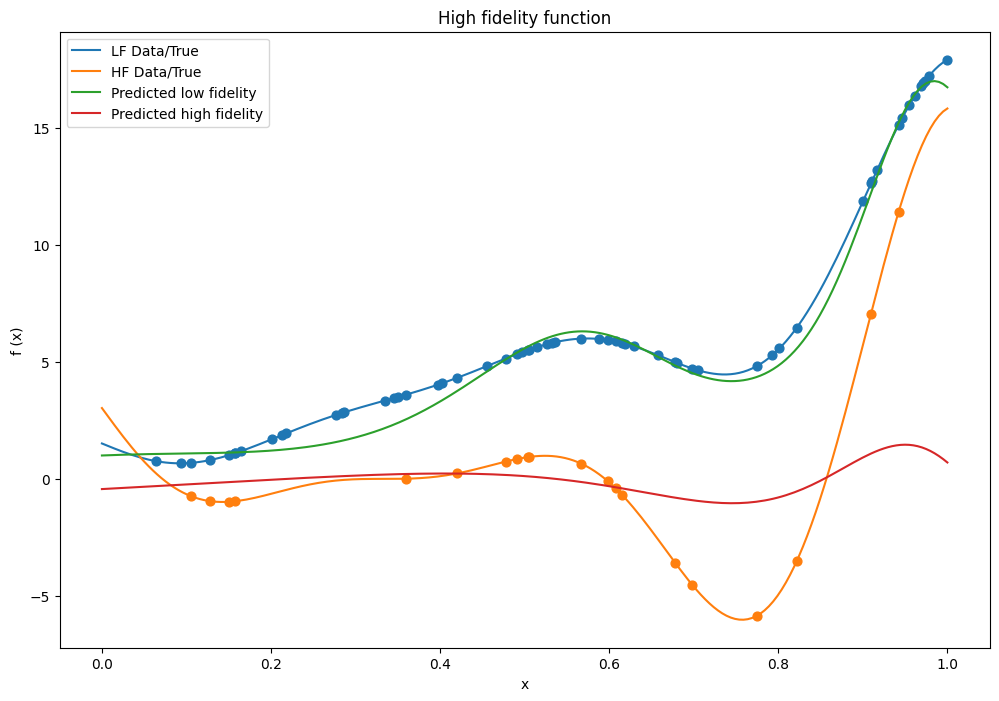

In [8]:
# Example usage
default_pysr_params = dict(
    populations=30,
    model_selection="best",
    denoise=True,
)

model = PySRRegressor(
    niterations=30,
    binary_operators=["+", "*", "-"],
    unary_operators=["cos", "exp", "sin", "square", "log"],
    **default_pysr_params,
)

default_pysr_params = dict(
    populations=30,
    model_selection="score",
    denoise=True,
)


model_mf = PySRRegressor(
    niterations=30,
    binary_operators=["+", "*", "-"],
    unary_operators=["cos", "exp", "sin", "square", "log"],
    **default_pysr_params,
)

# Fit the multi-fidelity model
model_mf_s = MultiFidelitySRegressor(model, model_mf, complexity=None)

model_mf_s.fit(x_train_l, y_train_l, x_train_h, y_train_h)

# Predict the high-fidelity function
y_predict_mf = model_mf_s(x_plot)
# predict the low-fidelity function
y_predict_l = model_mf_s.model.predict(x_plot)

plt.figure(figsize=(12, 8))
plt.plot(x_plot, y_plot_l, "C0")
plt.plot(x_plot, y_plot_h, "C1")
plt.plot(x_plot, y_predict_l, "C2")
plt.plot(x_plot, y_predict_mf, "C3")
plt.scatter(x_train_l, y_train_l, color="C0", s=40)
plt.scatter(x_train_h, y_train_h, color="C1", s=40)
plt.ylabel("f (x)")
plt.xlabel("x")
plt.legend(["LF Data/True", "HF Data/True", "Predicted low fidelity", "Predicted high fidelity"])
plt.title("High fidelity function")


I need a way to do

SR(f_lf) + SR(x_h) = f_h

Currently only

f_h - f_lf = SR(x_h)

This is probably easy - just make the input with (n_point, 2)

* It would be also nice to have GP to capture the residual as part of the uncertainty, i.e., effectively using SRegressor as the GP mean function

In [9]:
model_mf_s.sympy()[0]

(x0 + x0)**2 + (-x0*sin(exp(x0 + 1.8810159)) + exp(x0))**2

In [10]:
model_mf_s.sympy()[1]

(x0 + x0 - 0.43570226)*cos(x0*exp(2*x0))

In [11]:
model_mf

PySRRegressor.equations_ = [
	    pick         score                                           equation  \
	0         0.000000e+00                                                 x0   
	1         8.008410e-01                                   sin(-0.14655912)   
	2         1.047931e-07                             -1.001709 * 0.14578804   
	3         3.226479e-01                                       sin(x1) * x0   
	4         6.680503e-02                               sin(x1) * square(x0)   
	5         5.526279e-01                         sin(-0.34793884 * x1) * x0   
	6         4.774393e-01                  cos(square(exp(square(x0)))) * x0   
	7         1.614495e-01                     sin(x0 - square(exp(x0) * x0))   
	8         5.026754e-01     (cos(square(exp(square(x0)))) * x0) * 1.550297   
	9         3.400326e-01           sin(cos(log(x0)) - square(exp(x0) * x0))   
	10        1.696295e-01  ((x0 - 0.45093748) + x0) * cos(square(exp(squa...   
	11  >>>>  8.835614e-01  cos(x0 * square(exp(x0))) * ((x0 + -0.43570226...   
	12        2.713762e-01  (-0.2589551 + x0) * (cos(x0 * square(exp(x0)))...   
	13        3.036802e-01  (sin(cos(x0 * square(exp(x0)))) * exp(0.922049...   
	14        1.749537e-01  (sin(cos(x0 * square(exp(x0)))) * exp(cos(-0.2...   
	15        6.139543e-01  sin((exp(x0) * cos(square(exp(x0)) * x0)) * (x...   
	16        4.347461e-02  sin((cos(x0 * square(exp(x0))) * exp(x0)) * (x...   
	17        2.340338e-01  sin(((exp(x0) * cos(square(exp(x0)) * x0)) * (...   
	18        7.788138e-03  sin(((cos(square(exp(x0)) * x0) * exp(x0)) * s...   
	19        1.646729e-01  sin(sin(sin((x0 + -0.28677604) * (sin(cos(squa...   
	
	        loss  complexity  
	0   0.850214           1  
	1   0.381705           2  
	2   0.381705           3  
	3   0.276441           4  
	4   0.258577           5  
	5   0.148794           6  
	6   0.092308           7  
	7   0.078545           8  
	8   0.047513           9  
	9   0.033817          10  
	10  0.028541          11  
	11  0.011796          12  
	12  0.008993          13  
	13  0.006637          14  
	14  0.005572          15  
	15  0.003016          16  
	16  0.002887          17  
	17  0.002285          18  
	18  0.002267          19  
	19  0.001923          20  
]